# Fine-tune MedGemma for Dengue Fever Diagnosis

This notebook demonstrates fine-tuning MedGemma on a multimodal dengue fever diagnosis task using clinical data and medical images. The model will learn to classify patients as having dengue fever or not based on clinical symptoms, laboratory values, and associated medical images.

The fine-tuning uses:
- **Clinical Data**: CSV file containing patient symptoms, lab values, and dengue diagnosis
- **Medical Images**: Associated patient images showing potential dengue-related symptoms
- **Task**: Binary classification (dengue positive/negative)
- **Technique**: QLoRA (Quantized Low-Rank Adaptation) for efficient fine-tuning


## Setup

### Configure HF


In [ ]:
import os
import sys

if "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT"):
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Install dependencies

In [ ]:
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl pandas pillow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 136.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 60.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

## Prepare dengue diagnosis dataset

This implements **training** for dengue fever diagnosis with MedGemma:

### Training Strategy:
**Multimodal Training**: Train on both clinical data (CSV) and medical images simultaneously
- Single training pipeline that handles both text-only and image+text samples
- Dynamic data type detection during training
- Mixed batches containing both modalities
- Unified evaluation across both data types

### Dataset Components:
- **Clinical Text Data**: Patient records from CSV with symptoms, lab values, diagnosis
- **Medical Images**: Dengue-positive medical images for visual learning
- **Unified Approach**: Both modalities trained together in a single step


In [ ]:
import pandas as pd
import os
from PIL import Image
from datasets import Dataset, DatasetDict
from typing import Any, List, Dict
import glob
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/PDS I/train/train_dengue.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (98, 18)

Columns: ['dengue.p_i_d', 'dengue.date_of_fever', 'dengue.residence', 'dengue.days', 'dengue.current_temp', 'dengue.wbc', 'dengue.servere_headche', 'dengue.pain_behind_the_eyes', 'dengue.joint_muscle_aches', 'dengue.metallic_taste_in_the_mouth', 'dengue.appetite_loss', 'dengue.addominal_pain', 'dengue.nausea_vomiting', 'dengue.diarrhoea', 'dengue.hemoglobin', 'dengue._hematocri', 'dengue.platelet', 'dengue.dengue']

First few rows:


,dengue.p_i_d,dengue.date_of_fever,dengue.residence,dengue.days,dengue.current_temp,dengue.wbc,dengue.servere_headche,dengue.pain_behind_the_eyes,dengue.joint_muscle_aches,dengue.metallic_taste_in_the_mouth,dengue.appetite_loss,dengue.addominal_pain,dengue.nausea_vomiting,dengue.diarrhoea,dengue.hemoglobin,dengue._hematocri,dengue.platelet,dengue.dengue
0,P012,13-Jan,Bangalore,10 days,100.0,5.0,yes,no,no,yes,yes,yes,no,yes,15.0,NaN,140.0,yes
1,P011,13-Feb,New Delhi,4 days,104.0,1.0,no,yes,yes,no,no,no,no,no,9.0,22.0,80.0,no
2,P010,9-Jan,Jamica,5 days,104.0,5.0,NaN,no,no,yes,yes,yes,yes,no,NaN,NaN,120.0,yes
3,P009,12-Aug,Barbados,12 months,101.0,NaN,yes,yes,no,no,no,no,no,no,NaN,NaN,NaN,no
4,P008,12-Oct,St.Martin,3 days,101.0,NaN,yes,no,no,no,no,no,yes,no,NaN,NaN,NaN,no



Sample image:


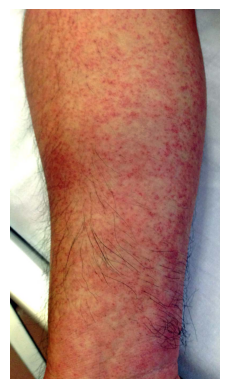

In [ ]:
print(f"\nSample image:")
img = Image.open('/content/drive/My Drive/PDS I/train/images/4650d3e0-f00e-4fe9-a057-9b9106d3d976_p1_img23_434c0412.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
df['dengue_binary'] = df['dengue.dengue'].map({'yes': 1, 'no': 0})
df = df.dropna(subset=['dengue_binary'])
df = df[df['dengue_binary'].notna()]

# For symptoms, distinguish between missing data (NaN) and explicit 'no' responses
symptom_columns = [
    'dengue.servere_headche', 'dengue.pain_behind_the_eyes',
    'dengue.joint_muscle_aches', 'dengue.metallic_taste_in_the_mouth',
    'dengue.appetite_loss', 'dengue.addominal_pain',
    'dengue.nausea_vomiting', 'dengue.diarrhoea'
]

# For non-symptom columns, fill with 'unknown' but handle symptoms differently
non_symptom_columns = [col for col in df.columns if col not in symptom_columns + ['dengue.dengue', 'dengue_binary']]
df[non_symptom_columns] = df[non_symptom_columns].fillna('unknown')

# For symptom columns, keep NaN to distinguish from explicit 'no'
# This helps the model understand when data is truly missing vs confirmed absent

print(f"\nText Training Dataset:")
print(f"Total clinical records: {len(df)}")
print(f"Dengue positive cases: {df['dengue_binary'].sum()}")
print(f"Dengue negative cases: {(df['dengue_binary'] == 0).sum()}")


image_base_path = "/content/drive/My Drive/PDS I/train/images"
image_files = glob.glob(f"{image_base_path}/*.png") + glob.glob(f"{image_base_path}/*.jpg") + glob.glob(f"{image_base_path}/*.jpeg")
print(f"\nImage Training Dataset:")
print(f"Total medical images: {len(image_files)} (all dengue positive)")


Text Training Dataset:
Total clinical records: 90
Dengue positive cases: 65.0
Dengue negative cases: 25

Image Training Dataset:
Total medical images: 26 (all dengue positive)


### Prepare Training Data

Create a dataset that combines both text-only and multimodal samples for simultaneous training.

In [ ]:
def create_clinical_summary(row):
    """Create a clinical summary from patient data with improved handling of unknown symptoms."""
    summary_parts = []

    # Demographics and basic info
    if row['dengue.residence'] != 'unknown':
        summary_parts.append(f"Patient from {row['dengue.residence']}")

    if row['dengue.days'] != 'unknown':
        summary_parts.append(f"fever duration: {row['dengue.days']}")

    if row['dengue.current_temp'] != 'unknown':
        summary_parts.append(f"current temperature: {row['dengue.current_temp']}°F")

    # Lab values with proper handling of unknowns
    lab_values = []
    lab_mapping = {
        'dengue.wbc': 'WBC',
        'dengue.hemoglobin': 'Hemoglobin',
        'dengue._hematocri': 'Hematocrit',
        'dengue.platelet': 'Platelet'
    }

    for col, lab_name in lab_mapping.items():
        if row[col] != 'unknown' and pd.notna(row[col]):
            lab_values.append(f"{lab_name}: {row[col]}")

    if lab_values:
        summary_parts.append(f"Lab values - {', '.join(lab_values)}")

    # Improved symptom handling
    symptom_mapping = {
        'dengue.servere_headche': 'severe headache',
        'dengue.pain_behind_the_eyes': 'pain behind eyes',
        'dengue.joint_muscle_aches': 'joint/muscle aches',
        'dengue.metallic_taste_in_the_mouth': 'metallic taste',
        'dengue.appetite_loss': 'appetite loss',
        'dengue.addominal_pain': 'abdominal pain',
        'dengue.nausea_vomiting': 'nausea/vomiting',
        'dengue.diarrhoea': 'diarrhea'
    }

    present_symptoms = []
    absent_symptoms = []
    unknown_symptoms = []

    for col, symptom_name in symptom_mapping.items():
        if pd.isna(row[col]):  # Truly missing data
            unknown_symptoms.append(symptom_name)
        elif row[col] == 'yes':  # Explicitly present
            present_symptoms.append(symptom_name)
        elif row[col] == 'no':   # Explicitly absent
            absent_symptoms.append(symptom_name)

    # Build symptom summary with clinical context
    if present_symptoms:
        summary_parts.append(f"Present symptoms: {', '.join(present_symptoms)}")

    if absent_symptoms:
        summary_parts.append(f"Absent symptoms: {', '.join(absent_symptoms)}")

    # Only mention unknown symptoms if there are many, to avoid cluttering
    if len(unknown_symptoms) > 0:
        if len(unknown_symptoms) <= 3:
            summary_parts.append(f"Symptom status unknown for: {', '.join(unknown_symptoms)}")
        else:
            summary_parts.append(f"Symptom status unknown for {len(unknown_symptoms)} symptoms")

    return '. '.join(summary_parts) + '.'

# Test the improved function
sample_summary = create_clinical_summary(df.iloc[0])
print(f"Sample clinical summary: {sample_summary}")
sample_summary = create_clinical_summary(df.iloc[1])
print(f"Sample clinical summary: {sample_summary}")
sample_summary = create_clinical_summary(df.iloc[2])
print(f"Sample clinical summary: {sample_summary}")

Sample improved clinical summary: Patient from Bangalore. fever duration: 10 days. current temperature: 100.0°F. Lab values - WBC: 5.0, Hemoglobin: 15.0, Platelet: 140.0. Present symptoms: severe headache, metallic taste, appetite loss, abdominal pain, diarrhea. Absent symptoms: pain behind eyes, joint/muscle aches, nausea/vomiting.
Sample improved clinical summary: Patient from New Delhi. fever duration: 4 days. current temperature: 104.0°F. Lab values - WBC: 1.0, Hemoglobin: 9.0, Hematocrit: 22.0, Platelet: 80.0. Present symptoms: pain behind eyes, joint/muscle aches. Absent symptoms: severe headache, metallic taste, appetite loss, abdominal pain, nausea/vomiting, diarrhea.
Sample improved clinical summary: Patient from Jamica. fever duration: 5 days. current temperature: 104.0°F. Lab values - WBC: 5.0, Platelet: 120.0. Present symptoms: metallic taste, appetite loss, abdominal pain, nausea/vomiting. Absent symptoms: pain behind eyes, joint/muscle aches, diarrhea. Symptom status unkn

In [ ]:
def format_text_only_data(row):
    """Format clinical text data for training (text-only samples)."""
    clinical_summary = create_clinical_summary(row)

    prompt = f"""Based on the following clinical presentation, please diagnose whether this patient has dengue fever.

Clinical Information:
{clinical_summary}

Based on the clinical data above, does this patient have dengue fever?

Respond with either "Yes - Dengue positive" or "No - Dengue negative"."""

    answer = "Yes - Dengue positive" if row['dengue_binary'] == 1 else "No - Dengue negative"

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": answer,
                    },
                ],
            },
        ],
        "label": row['dengue_binary'],
        "data_type": "text_only",
        "image": None
    }

def format_multimodal_data(image_path):
    """Format image data for unified training (multimodal samples)."""

    prompt = """Analyze this medical image for signs of dengue fever.

Based on the visual evidence in this medical image, does this show signs consistent with dengue fever?

Respond with "Yes - Dengue positive" since this image shows dengue-related symptoms."""

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                    },
                    {
                        "type": "text",
                        "text": prompt,
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": "Yes - Dengue positive",
                    },
                ],
            },
        ],
        "image": image_path,
        "label": 1,
        "data_type": "multimodal"
    }


sample_text_formatted = format_text_only_data(df.iloc[0])
sample_multimodal_formatted = format_multimodal_data(image_files[0])

print("Format created successfully")
print(f"Text sample type: {sample_text_formatted['data_type']}")
print(f"Text sample label: {sample_text_formatted['label']}")

print(f"\nMultimodal sample type: {sample_multimodal_formatted['data_type']}")
print(f"Multimodal sample label: {sample_multimodal_formatted['label']}")
print(f"Image path: {sample_multimodal_formatted['image']}")

Format created successfully
Text sample type: text_only
Text sample label: 1.0

Multimodal sample type: multimodal
Multimodal sample label: 1
Image path: /content/drive/My Drive/PDS I/train/images/583bf3b6-9e70-46f3-abaf-bd7f9e209c41_p3_img1_cf211366.png


In [ ]:
print("=== TRAINING DATASET ===")

unified_dataset_list = []

print("Processing text-only samples from CSV...")
for idx, row in df.iterrows():
    try:
        formatted_data = format_text_only_data(row)
        unified_dataset_list.append(formatted_data)
    except Exception as e:
        print(f"Error processing text row {idx}: {e}")
        continue

print(f"Successfully processed {len(unified_dataset_list)} text-only samples")

print("\nProcessing multimodal samples from images...")
image_samples_added = 0
for image_path in image_files:
    try:
        img = Image.open(image_path).convert('RGB')
        formatted_data = format_multimodal_data(image_path)
        formatted_data['image'] = img
        unified_dataset_list.append(formatted_data)
        image_samples_added += 1
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        continue

print(f"Successfully processed {image_samples_added} multimodal samples")

unified_dataset = Dataset.from_list(unified_dataset_list)

from datasets import ClassLabel
unified_dataset = unified_dataset.cast_column("label", ClassLabel(names=["No Dengue", "Dengue"]))

if len(unified_dataset) <= 5:
    print("Small dataset detected - using simple split")
    unified_train_test_split = unified_dataset.train_test_split(test_size=0.3, seed=42)
else:
    unified_train_test_split = unified_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")

unified_data = DatasetDict({
    "train": unified_train_test_split["train"],
    "validation": unified_train_test_split["test"]
})


train_text_count = sum(1 for sample in unified_data["train"] if sample["data_type"] == "text_only")
train_multimodal_count = sum(1 for sample in unified_data["train"] if sample["data_type"] == "multimodal")
val_text_count = sum(1 for sample in unified_data["validation"] if sample["data_type"] == "text_only")
val_multimodal_count = sum(1 for sample in unified_data["validation"] if sample["data_type"] == "multimodal")

print(f"\nDataset Splits:")
print(f"  Train: {len(unified_data['train'])} samples")
print(f"    - Text-only: {train_text_count} samples")
print(f"    - Multimodal: {train_multimodal_count} samples")
print(f"  Validation: {len(unified_data['validation'])} samples")
print(f"    - Text-only: {val_text_count} samples")
print(f"    - Multimodal: {val_multimodal_count} samples")


train_positive = sum(unified_data['train']['label'])
train_negative = len(unified_data['train']) - train_positive
val_positive = sum(unified_data['validation']['label'])
val_negative = len(unified_data['validation']) - val_positive

print(f"\nLabel Distribution:")
print(f"  Train - Positive: {train_positive}, Negative: {train_negative}")
print(f"  Validation - Positive: {val_positive}, Negative: {val_negative}")

print(f"\n=== TRAINING SUMMARY ===")
print(f"Total samples: {len(unified_dataset_list)}")
print(f"Text-only samples: {len(unified_dataset_list) - image_samples_added}")
print(f"Multimodal samples: {image_samples_added}")

=== TRAINING DATASET ===
Processing text-only samples from CSV...
Successfully processed 90 text-only samples

Processing multimodal samples from images...
Successfully processed 26 multimodal samples


Casting the dataset:   0%|          | 0/116 [00:00<?, ? examples/s]


Dataset Splits:
  Train: 92 samples
    - Text-only: 70 samples
    - Multimodal: 22 samples
  Validation: 24 samples
    - Text-only: 20 samples
    - Multimodal: 4 samples

Label Distribution:
  Train - Positive: 72, Negative: 20
  Validation - Positive: 19, Negative: 5

=== TRAINING SUMMARY ===
Total samples: 116
Text-only samples: 90
Multimodal samples: 26


## Fine-tuning with QLoRA

Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

Fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

### Load model from Hugging Face Hub


In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/gemma-3-4b-it"

if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

### Set up for fine-tuning


In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
from typing import Any

def unified_collate_fn(examples: list[dict[str, Any]]):

    text_only_examples = [ex for ex in examples if ex["data_type"] == "text_only"]
    multimodal_examples = [ex for ex in examples if ex["data_type"] == "multimodal"]

    if text_only_examples and multimodal_examples:
        if len(text_only_examples) >= len(multimodal_examples):
            examples = text_only_examples
        else:
            examples = multimodal_examples

    batch_type = examples[0]["data_type"]

    if batch_type == "text_only":
        texts = []
        for example in examples:
            text = processor.apply_chat_template(
                example["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
            texts.append(text)

        batch = processor(text=texts, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100

    else:
        texts = []
        images = []
        for example in examples:
            text = processor.apply_chat_template(
                example["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
            texts.append(text)
            images.append([example["image"].convert("RGB")])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()

        labels[labels == processor.tokenizer.pad_token_id] = -100

        try:
            image_token_id = processor.tokenizer.convert_tokens_to_ids(
                processor.tokenizer.special_tokens_map["boi_token"]
            )
            labels[labels == image_token_id] = -100
        except KeyError:
            pass

        labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [ ]:
from trl import SFTConfig

num_train_epochs = 10
learning_rate = 1e-4

unified_args = SFTConfig(
    output_dir="gemma-4b-dengue-diagnosis",                # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=2,                           # Smaller batch size for medical data
    per_device_eval_batch_size=2,                            # Smaller batch size for medical data
    gradient_accumulation_steps=2,                           # Higher accumulation for effective batch size
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=2,                                         # More frequent logging for small dataset
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",
    eval_steps=2,
    learning_rate=learning_rate,                             # Learning rate for medical domain
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                        # Higher warmup for medical domain
    lr_scheduler_type="cosine",                              # Cosine scheduler for better convergence
    push_to_hub=True,                                        # Push model to Hub
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

### Train on Both Text and Image Data



In [ ]:
print("=== MULTIMODAL TRAINING ===")

from trl import SFTTrainer

unified_trainer = SFTTrainer(
    model=model,
    args=unified_args,
    train_dataset=unified_data["train"],
    eval_dataset=unified_data["validation"],
    peft_config=peft_config,
    processing_class=processor,
    data_collator=unified_collate_fn,
)
print("Starting training...")
print(f"Training on {len(unified_data['train'])} total samples:")
print(f"  - Text-only: {train_text_count} samples")
print(f"  - Multimodal: {train_multimodal_count} samples")

=== MULTIMODAL TRAINING ===
Starting training...
Training on 92 total samples:
  - Text-only: 70 samples
  - Multimodal: 22 samples


In [ ]:
unified_training_result = unified_trainer.train()
print("Training completed!")

unified_trainer.save_model()
print(f"Model saved to {unified_args.output_dir}")

print("\n=== TRAINING COMPLETED ===")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
2,10.511300,5.381123,0.647627,1175.000000,0.464797
4,10.200100,4.738724,0.697710,2083.000000,0.485824
6,8.600800,3.323571,0.892877,2969.000000,0.560156
8,5.585100,2.245412,1.181062,4063.000000,0.638363
10,4.279200,1.627486,1.281593,4872.000000,0.692658
12,3.940800,1.226145,1.250339,6239.000000,0.753538
14,2.324900,0.832817,1.098715,7134.000000,0.835016
16,1.499200,0.586783,0.880098,7993.000000,0.882571
18,1.134500,0.470113,0.643946,8843.000000,0.899045
20,0.749800,0.408263,0.510596,9764.000000,0.916014


Training completed!


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...agnosis/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...16390.eafbaef3533e.5638.0: 100%|##########|  102kB /  102kB            

  ...diagnosis/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...-diagnosis/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...adapter_model.safetensors:   1%|1         | 41.9MB / 2.84GB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model saved to gemma-4b-dengue-diagnosis

=== TRAINING COMPLETED ===


## Evaluate the fine-tuned model


In [ ]:
del unified_trainer
del model

NameError: name 'unified_trainer' is not defined

In [ ]:
torch.cuda.empty_cache()

### Set up for evaluation

In [ ]:
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_detailed_metrics(predictions: list[int], references: list[int]) -> dict[str, float]:
    """Compute comprehensive evaluation metrics for dengue classification."""
    metrics = {}

    metrics.update(accuracy_metric.compute(predictions=predictions, references=references))

    # Ensure f1, precision, and recall are always computed, even if some classes are missing
    try:
        metrics.update(f1_metric.compute(predictions=predictions, references=references, average="weighted"))
    except ValueError:
        metrics["f1"] = 0.0 # Assign 0 if computation fails (e.g., no samples for a class)

    try:
        metrics.update(precision_metric.compute(predictions=predictions, references=references, average="weighted"))
    except ValueError:
        metrics["precision"] = 0.0

    try:
        metrics.update(recall_metric.compute(predictions=predictions, references=references, average="weighted"))
    except ValueError:
        metrics["recall"] = 0.0


    if len(set(references)) == 2:
        try:
            metrics.update(f1_metric.compute(predictions=predictions, references=references, average="binary"))
            metrics["f1_binary"] = metrics.pop("f1") # Rename the binary f1
            # Re-compute weighted f1 explicitly after popping the binary one
            metrics["f1_weighted"] = f1_metric.compute(predictions=predictions, references=references, average="weighted")["f1"]
        except ValueError:
             metrics["f1_binary"] = 0.0
             metrics["f1_weighted"] = metrics.get("f1", 0.0) # Use the possibly already computed weighted or 0

    return metrics

def postprocess_dengue_response(response_text: str) -> int:
    """Extract dengue diagnosis from model response with improved parsing."""
    response_text = response_text.lower().strip()

    # More comprehensive positive patterns
    positive_patterns = [
        "yes - dengue positive",
        "dengue positive",
        "yes, dengue positive",
        "positive for dengue",
        "dengue fever positive",
        "has dengue",
        "dengue diagnosis: positive",
        "positive",
        "yes"
    ]

    negative_patterns = [
        "no - dengue negative",
        "dengue negative",
        "no, dengue negative",
        "negative for dengue",
        "dengue fever negative",
        "no dengue",
        "dengue diagnosis: negative",
        "negative",
        "no"
    ]

    # Check positive patterns first (more specific to less specific)
    for pattern in positive_patterns:
        if pattern in response_text:
            return 1

    # Then check negative patterns (more specific to less specific)
    for pattern in negative_patterns:
        if pattern in response_text:
            return 0

    # Additional heuristics - look for key medical indicators
    if any(word in response_text for word in ["fever", "platelet", "headache", "symptoms"]):
        # If mentions medical terms, try to infer from context
        if any(word in response_text for word in ["consistent", "likely", "probable", "suggests"]):
            return 1
        elif any(word in response_text for word in ["unlikely", "not consistent", "does not", "cannot"]):
            return 0

    # Default to unknown if can't parse
    print(f"    Warning: Could not parse response: '{response_text[:200]}...'")
    return -1

print("Evaluation metrics setup completed.")

Evaluation metrics setup completed.


In [ ]:
# Prepare evaluation data
from google.colab import drive
drive.mount('/content/drive')

eval_df = pd.read_csv("/content/drive/My Drive/PDS I/eval/eval_dengue.csv")
eval_df = eval_df.fillna('unknown')

eval_df['dengue_binary'] = eval_df['dengue.dengue'].map({'yes': 1, 'no': 0})

eval_df = eval_df.dropna(subset=['dengue_binary'])
eval_df = eval_df[eval_df['dengue_binary'].notna()]

print(f"\nEvaluation Dataset:")
print(f"Total clinical records: {len(eval_df)}")
print(f"Dengue positive cases: {eval_df['dengue_binary'].sum()}")
print(f"Dengue negative cases: {(eval_df['dengue_binary'] == 0).sum()}")


image_eval_base_path = "/content/drive/My Drive/PDS I/eval/images"
eval_image_files = glob.glob(f"{image_eval_base_path}/*.png") + glob.glob(f"{image_eval_base_path}/*.jpg") + glob.glob(f"{image_eval_base_path}/*.jpeg")
print(f"\nEvaluation images: {len(eval_image_files)}")

eval_dataset_list = []

for idx, row in eval_df.iterrows():
    try:
        formatted_data = format_text_only_data(row)
        eval_dataset_list.append(formatted_data)
    except Exception as e:
        print(f"Error processing eval row {idx}: {e}")
        continue

for image_path in eval_image_files:
    try:
        img = Image.open(image_path).convert('RGB')
        formatted_data = format_multimodal_data(image_path)
        formatted_data['image'] = img
        eval_dataset_list.append(formatted_data)
    except Exception as e:
        print(f"Error processing eval image {image_path}: {e}")
        continue

print(f"\nTotal evaluation samples: {len(eval_dataset_list)}")
print(f"Text-only samples: {len(eval_df)}")
print(f"Multimodal samples: {len(eval_image_files)}")

text_eval_samples = [sample for sample in eval_dataset_list if sample.get('data_type') == 'text_only']
multimodal_eval_samples = [sample for sample in eval_dataset_list if sample.get('data_type') == 'multimodal']

print(f"\nSeparated for evaluation:")
print(f"Text-only evaluation samples: {len(text_eval_samples)}")
print(f"Multimodal evaluation samples: {len(multimodal_eval_samples)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Evaluation Dataset:
Total clinical records: 9
Dengue positive cases: 7.0
Dengue negative cases: 2

Evaluation images: 5

Total evaluation samples: 14
Text-only samples: 9
Multimodal samples: 5

Separated for evaluation:
Text-only evaluation samples: 9
Multimodal evaluation samples: 5


In [ ]:
from transformers import pipeline
import torch

print("=== LOADING FINE-TUNED MODEL ===")

ft_model_path = "gemma-4b-dengue-diagnosis"

try:
    ft_pipe = pipeline(
        "image-text-to-text",
        model=ft_model_path,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
    )

    ft_pipe.model.generation_config.do_sample = False
    ft_pipe.model.generation_config.pad_token_id = ft_pipe.tokenizer.eos_token_id

    ft_pipe.tokenizer.padding_side = "left"

    print(f"Successfully loaded fine-tuned model from Hugging Face Hub: {ft_model_path}")

except Exception as e:
    print(f"Error loading fine-tuned model from Hub: {e}")

    try:
        ft_pipe = pipeline(
            "image-text-to-text",
            model="./gemma-4b-dengue-diagnosis",
            processor=processor,
            torch_dtype=torch.bfloat16,
        )

        ft_pipe.model.generation_config.do_sample = False
        ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
        ft_pipe.tokenizer.padding_side = "left"

        print("Successfully loaded fine-tuned model from local path")

    except Exception as local_error:
        print(f"Error loading from local path: {local_error}")

=== LOADING FINE-TUNED MODEL ===


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Successfully loaded fine-tuned model from Hugging Face Hub: gemma-4b-dengue-diagnosis


In [ ]:
# Run evaluation on both text-only and multimodal samples
print("=== MODEL EVALUATION ===")

# Initialize evaluation data structures
all_predictions = []
all_references = []
text_predictions = []
text_references = []
multimodal_predictions = []
multimodal_references = []

# Check if model loaded successfully
try:
    # Test the model with a simple medical prompt
    test_prompt = "Based on clinical symptoms of fever and headache, is this dengue? Respond with Yes or No."
    test_response = ft_pipe(test_prompt, max_new_tokens=50, return_full_text=False)
    print(f"Model test response: {test_response}")
except Exception as e:
    print(f"Model test failed: {e}")
    print("The model may not have loaded correctly. Please check the previous cells.")

# Check what special tokens are available
print(f"Available special tokens: {list(ft_pipe.tokenizer.special_tokens_map.keys())}")

# Evaluate text-only samples
print(f"\nEvaluating {len(text_eval_samples)} text-only samples...")

if len(text_eval_samples) > 0:
    # Iterate through all text-only evaluation samples
    for i, sample in enumerate(text_eval_samples):
        try:
            messages = sample["messages"]
            ref = sample["label"]

            # Use the chat template for text-only samples
            try:
                chat_text = ft_pipe.tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )
                input_text = chat_text

                # Run inference
                output = ft_pipe(
                    input_text,
                    max_new_tokens=200, # Increased max_new_tokens
                    return_full_text=False,
                    temperature=0.1,  # Low temperature for more consistent outputs
                )

                # Extract response
                response_text = ""
                if isinstance(output, list) and len(output) > 0:
                    if isinstance(output[0], dict) and "generated_text" in output[0]:
                        response_text = output[0]["generated_text"].strip()
                    else:
                        # Attempt to convert other list formats
                        try:
                            response_text = str(output[0]).strip()
                        except Exception:
                            pass # Keep response_text as empty if conversion fails
                else:
                    # Attempt to convert other output formats
                    try:
                        response_text = str(output).strip()
                    except Exception:
                        pass # Keep response_text as empty if conversion fails


                # print(f"  Sample {i+1} Text Response: '{response_text}'") # Uncomment for debugging

                if response_text and len(response_text) > 0:
                    # Try to parse the response
                    pred = postprocess_dengue_response(response_text)

                    if pred != -1:  # Valid prediction
                        text_predictions.append(pred)
                        text_references.append(ref)
                        # print(f"  ✓ Text-only prediction: {'Positive' if pred == 1 else 'Negative'} (Expected: {'Positive' if ref == 1 else 'Negative'})") # Uncomment for debugging
                    else:
                        print(f"  Warning: Could not parse text response for sample {i+1}: '{response_text[:100]}...'")
                else:
                    print(f"  Warning: Empty text response for sample {i+1}")
                    print(f"    Input text: {input_text[:200]}...") # Add debug print for empty response
                    print(f"    Raw output: {output}") # Add debug print for raw output


            except Exception as text_e:
                print(f"  Error processing text sample {i+1}: {text_e}")
                continue

        except Exception as e:
            print(f"Error in text sample loop {i+1}: {e}")
            continue

    print(f"✓ Finished evaluating {len(text_eval_samples)} text-only samples")

# Evaluate multimodal samples using direct model inference
print(f"\nEvaluating {len(multimodal_eval_samples)} multimodal samples using direct model inference...")

if len(multimodal_eval_samples) > 0:
    # Get the model and processor directly from the pipeline
    model = ft_pipe.model
    processor = ft_pipe.tokenizer # Use the tokenizer from the pipeline

    # Set padding side for generation
    processor.padding_side = "left"

    # Try to find the correct image token from available special tokens
    image_token = None
    for token_name in ['image_token', 'boi_token']: # Check common names
        if token_name in processor.special_tokens_map:
            image_token = processor.special_tokens_map[token_name]
            break

    if image_token is None:
        print("Warning: Could not find a suitable image token in the tokenizer's special tokens map.")
        print("Multimodal evaluation may fail.")
        # Fallback to a common placeholder if no special token is found
        image_token = "<image>"


    for i, sample in enumerate(multimodal_eval_samples):
        try:
            messages = sample["messages"]
            image = sample["image"]
            ref = sample["label"]

            # Manually construct the prompt with the image token placed before the text
            prompt_text = ""
            for content_item in messages[0]["content"]:
                if content_item["type"] == "text":
                    prompt_text = content_item["text"]
                    break

            # Construct the prompt string with the image token explicitly
            prompt_with_image_token = f"{image_token}\n{prompt_text}"


            try:
                # Prepare inputs using the processor with the text containing the image token and the image
                inputs = processor(text=prompt_with_image_token, images=image, return_tensors="pt", padding=True)

                # Move inputs to the same device as the model
                inputs = {k: v.to(model.device) for k, v in inputs.items()}

                # Generate response directly from the model
                output_ids = model.generate(
                    **inputs,
                    max_new_tokens=100,
                    temperature=0.1,
                    pad_token_id=processor.eos_token_id # Use eos_token_id for padding
                )

                # Decode the generated tokens
                # Need to decode from the point after the input prompt
                # Find the length of the input prompt
                input_length = inputs["input_ids"].shape[1]
                generated_text = processor.decode(output_ids[0, input_length:], skip_special_tokens=True)
                response_text = generated_text.strip()

                # print(f"  Sample {i+1} Multimodal Response: '{response_text}'") # Uncomment for debugging

                if response_text and len(response_text) > 0:
                    pred = postprocess_dengue_response(response_text)
                    if pred != -1:
                        multimodal_predictions.append(pred)
                        multimodal_references.append(ref)
                        # print(f"  ✓ Multimodal prediction: {'Positive' if pred == 1 else 'Negative'} (Expected: {'Positive' if ref == 1 else 'Negative'})") # Uncomment for debugging
                    else:
                        print(f"  Warning: Could not parse multimodal response for sample {i+1}: '{response_text[:100]}...'")
                else:
                    print(f"  Warning: Empty multimodal response for sample {i+1}")


            except Exception as multimodal_e:
                 print(f"  Error during multimodal inference for sample {i+1}: {multimodal_e}")
                 continue

        except Exception as e:
            print(f"Error in multimodal sample loop {i+1}: {e}")
            continue

    print(f"✓ Finished evaluating {len(multimodal_eval_samples)} multimodal samples")


# Combine all predictions for overall metrics
all_predictions = text_predictions + multimodal_predictions
all_references = text_references + multimodal_references

print(f"\n=== EVALUATION SUMMARY ===")
print(f"Total evaluation samples attempted: {len(text_eval_samples) + len(multimodal_eval_samples)}")
print(f"Total valid predictions generated: {len(all_predictions)}")
print(f"Text-only predictions: {len(text_predictions)}")
print(f"Multimodal predictions: {len(multimodal_predictions)}")

# Now, compute and display the detailed metrics using the collected predictions and references
print("\nComputing detailed metrics...")

if len(all_predictions) > 0:
    # Overall unified model performance
    overall_metrics = compute_detailed_metrics(all_predictions, all_references)
    print(f"\nOVERALL UNIFIED MODEL PERFORMANCE:")
    print(f"   Accuracy: {overall_metrics['accuracy']:.3f}")
    print(f"   F1-Score (Weighted): {overall_metrics['f1']:.3f}")
    print(f"   Precision (Weighted): {overall_metrics['precision']:.3f}")
    print(f"   Recall (Weighted): {overall_metrics['recall']:.3f}")

    if 'f1_binary' in overall_metrics:
        print(f"   F1-Score (Binary): {overall_metrics['f1_binary']:.3f}")
    if 'f1_weighted' in overall_metrics:
        print(f"   F1-Score (Weighted - check): {overall_metrics['f1_weighted']:.3f}")


    # Text-only performance
    if len(text_predictions) > 0:
        text_metrics = compute_detailed_metrics(text_predictions, text_references)
        print(f"\n📝 TEXT-ONLY PERFORMANCE:")
        print(f"   Samples: {len(text_predictions)}")
        print(f"   Accuracy: {text_metrics['accuracy']:.3f}")
        print(f"   F1-Score: {text_metrics['f1']:.3f}")
        print(f"   Precision: {text_metrics['precision']:.3f}")
        print(f"   Recall: {text_metrics['recall']:.3f}")

    # Multimodal performance
    if len(multimodal_predictions) > 0:
        multimodal_metrics = compute_detailed_metrics(multimodal_predictions, multimodal_references)
        print(f"\nMULTIMODAL PERFORMANCE:")
        print(f"   Samples: {len(multimodal_predictions)}")
        print(f"   Accuracy: {multimodal_metrics['accuracy']:.3f}")
        print(f"   F1-Score: {multimodal_metrics['f1']:.3f}")
        print(f"   Precision: {multimodal_metrics['precision']:.3f}")
        print(f"   Recall: {multimodal_metrics['recall']:.3f}")

    # Detailed classification report
    print(f"\nDETAILED CLASSIFICATION REPORT:")
    try:
        print(classification_report(
            all_references,
            all_predictions,
            target_names=["No Dengue", "Dengue Positive"],
            digits=3
        ))
    except ValueError as e:
         print(f"Could not generate classification report: {e}")
         print("This might happen if there are no samples for one of the classes in the predictions/references.")


    # Confusion Matrix
    print(f"\n🔍 CONFUSION MATRIX:")
    try:
        cm = confusion_matrix(all_references, all_predictions)
        print("              Predicted")
        print("              No    Yes")
        print(f"Actual No  : {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"Actual Yes : {cm[1,0]:4d}  {cm[1,1]:4d}")
    except ValueError as e:
        print(f"Could not generate confusion matrix: {e}")
        print("This might happen if there are no samples for one of the classes in the predictions/references.")


    # Performance breakdown by data type
    if len(text_predictions) > 0 and len(multimodal_predictions) > 0:
        print(f"\nPERFORMANCE COMPARISON:")
        print(f"Text-only Accuracy:   {text_metrics['accuracy']:.3f}")
        print(f"Multimodal Accuracy:  {multimodal_metrics['accuracy']:.3f}")
        print(f"Improvement:          {multimodal_metrics['accuracy'] - text_metrics['accuracy']:+.3f}")

        print(f"\nText-only F1:         {text_metrics['f1']:.3f}")
        print(f"Multimodal F1:        {multimodal_metrics['f1']:.3f}")
        print(f"F1 Improvement:       {multimodal_metrics['f1'] - text_metrics['f1']:+.3f}")

else:
    print("⚠️ No valid predictions were generated for evaluation.")
    print("Please check the model loading and inference configuration.")

print("\n=== EVALUATION COMPLETED ===")

=== MODEL EVALUATION ===
Model test response: [{'input_text': 'Based on clinical symptoms of fever and headache, is this dengue? Respond with Yes or No.', 'generated_text': '\n'}]
Available special tokens: ['bos_token', 'eos_token', 'unk_token', 'pad_token', 'boi_token', 'eoi_token', 'image_token']

Evaluating 9 text-only samples...
    Input text: <bos><start_of_turn>user
Based on the following clinical presentation, please diagnose whether this patient has dengue fever.

Clinical Information:
Patient from Jamica. fever duration: 5 days. curren...
    Raw output: [{'input_text': '<bos><start_of_turn>user\nBased on the following clinical presentation, please diagnose whether this patient has dengue fever.\n\nClinical Information:\nPatient from Jamica. fever duration: 5 days. current temperature: 104.0°F. Lab values - WBC: 5.0, Platelet: 120.0. Present symptoms: metallic taste, appetite loss, abdominal pain, nausea/vomiting. Absent symptoms: pain behind eyes, joint/muscle aches, diarrhe

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyError: 'f1'

In [ ]:
from transformers import pipeline

question = "Patient from New Delhi. fever duration: 4 days. current temperature: 104°F. Lab values - WBC: 1.0, Hemoglobin: 9.0, Platelet: 80.0. Symptoms: joint_muscle_aches, pain_behind_the_eyes. Does Patient has dengue fever?"
generator = pipeline("text-generation", model="google/gemma-3-4b-it", device="cuda")
output = generator([{"role": "user", "content": question}], max_new_tokens=128, return_full_text=False)[0]
print(output["generated_text"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


Okay, let's analyze this patient's case and assess the likelihood of dengue fever.

**Here's a breakdown of the information and my assessment:**

**1. Patient Information:**

* **Location:** New Delhi (Important - Dengue prevalence varies by region)
* **Fever Duration:** 4 days - This is a concerning duration, suggesting a potentially serious infection.
* **Current Temperature:** 104°F (40°C) - This is a high fever and warrants immediate attention.
* **Lab Values:**
    * **WBC: 1.0 (Very


In [ ]:
# question = "Patient from Bangalore. fever duration: 10 days. current temperature: 100.0°F. Lab values - WBC: 5.0, Hemoglobin: 15.0, Platelet: 140.0. Symptoms: severe headache, metallic taste, appetite loss, abdominal pain, diarrhea. Does Patient has dengue fever?"
question = "Patient from New Delhi. fever duration: 4 days. current temperature: 104°F. Lab values - WBC: 1.0, Hemoglobin: 9.0, Platelet: 80.0. Symptoms: joint_muscle_aches, pain_behind_the_eyes. Does Patient has dengue fever?"
generator = pipeline("text-generation", model="longbao128/gemma-4b-dengue-diagnosis", device="cuda")
output = generator([{"role": "user", "content": question}], max_new_tokens=128, return_full_text=False)[0]
print(output["generated_text"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


Based on the clinical data you've provided, this patient does have significant concerns and dengue fever should be strongly considered. Here's a breakdown of why, and what further steps are needed:

**Reasons to Suspect Dengue:**

* **Fever duration: 4 days:** Dengue often presents with a biphasic fever pattern, although not always.
* **Current temperature: 104°F (40°C):** This is a high temperature consistent with dengue.
* **Lab values - WBC: 1.0:** This is *extremely* low. A WBC of 1


In [ ]:
del generator
torch.cuda.empty_cache()

In [ ]:
# Compute and display detailed evaluation metrics
print("=== DETAILED EVALUATION RESULTS ===")

if len(all_predictions) > 0:
    # Overall unified model performance
    overall_metrics = compute_detailed_metrics(all_predictions, all_references)
    print(f"\nOVERALL UNIFIED MODEL PERFORMANCE:")
    print(f"   Accuracy: {overall_metrics['accuracy']:.3f}")
    print(f"   F1-Score (Weighted): {overall_metrics['f1']:.3f}")
    print(f"   Precision (Weighted): {overall_metrics['precision']:.3f}")
    print(f"   Recall (Weighted): {overall_metrics['recall']:.3f}")

    if 'f1_binary' in overall_metrics:
        print(f"   F1-Score (Binary): {overall_metrics['f1_binary']:.3f}")

    # Text-only performance
    if len(text_predictions) > 0:
        text_metrics = compute_detailed_metrics(text_predictions, text_references)
        print(f"\n📝 TEXT-ONLY PERFORMANCE:")
        print(f"   Samples: {len(text_predictions)}")
        print(f"   Accuracy: {text_metrics['accuracy']:.3f}")
        print(f"   F1-Score: {text_metrics['f1']:.3f}")
        print(f"   Precision: {text_metrics['precision']:.3f}")
        print(f"   Recall: {text_metrics['recall']:.3f}")

    # Multimodal performance
    if len(multimodal_predictions) > 0:
        multimodal_metrics = compute_detailed_metrics(multimodal_predictions, multimodal_references)
        print(f"\nMULTIMODAL PERFORMANCE:")
        print(f"   Samples: {len(multimodal_predictions)}")
        print(f"   Accuracy: {multimodal_metrics['accuracy']:.3f}")
        print(f"   F1-Score: {multimodal_metrics['f1']:.3f}")
        print(f"   Precision: {multimodal_metrics['precision']:.3f}")
        print(f"   Recall: {multimodal_metrics['recall']:.3f}")

    # Detailed classification report
    print(f"\nDETAILED CLASSIFICATION REPORT:")
    print(classification_report(
        all_references,
        all_predictions,
        target_names=["No Dengue", "Dengue Positive"],
        digits=3
    ))

    # Confusion Matrix
    print(f"\n🔍 CONFUSION MATRIX:")
    cm = confusion_matrix(all_references, all_predictions)
    print("              Predicted")
    print("              No    Yes")
    print(f"Actual No  : {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"Actual Yes : {cm[1,0]:4d}  {cm[1,1]:4d}")

    # Performance breakdown by data type
    if len(text_predictions) > 0 and len(multimodal_predictions) > 0:
        print(f"\nPERFORMANCE COMPARISON:")
        print(f"Text-only Accuracy:   {text_metrics['accuracy']:.3f}")
        print(f"Multimodal Accuracy:  {multimodal_metrics['accuracy']:.3f}")
        print(f"Improvement:          {multimodal_metrics['accuracy'] - text_metrics['accuracy']:+.3f}")

        print(f"\nText-only F1:         {text_metrics['f1']:.3f}")
        print(f"Multimodal F1:        {multimodal_metrics['f1']:.3f}")
        print(f"F1 Improvement:       {multimodal_metrics['f1'] - text_metrics['f1']:+.3f}")

else:
    print("⚠️ No valid predictions were generated for evaluation.")
    print("Please check the model loading and inference configuration.")

print("\n=== EVALUATION COMPLETED ===")

=== DETAILED EVALUATION RESULTS ===
⚠️ No valid predictions were generated for evaluation.
Please check the model loading and inference configuration.

=== EVALUATION COMPLETED ===
